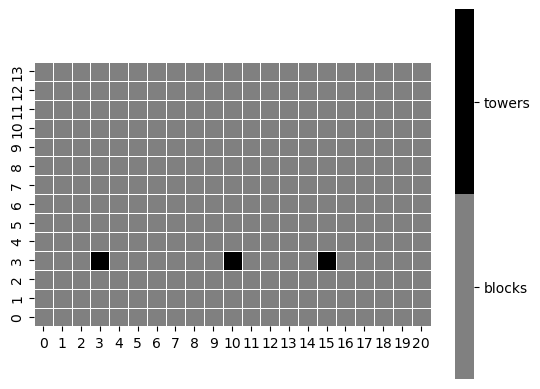

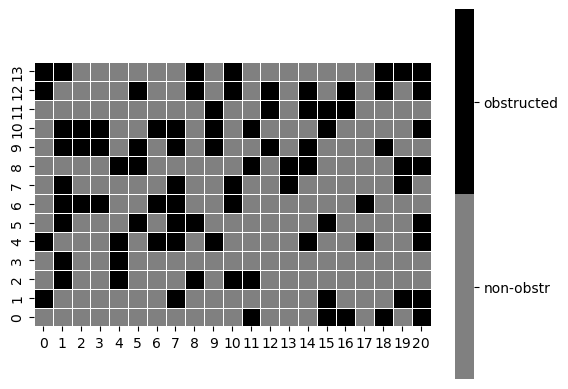

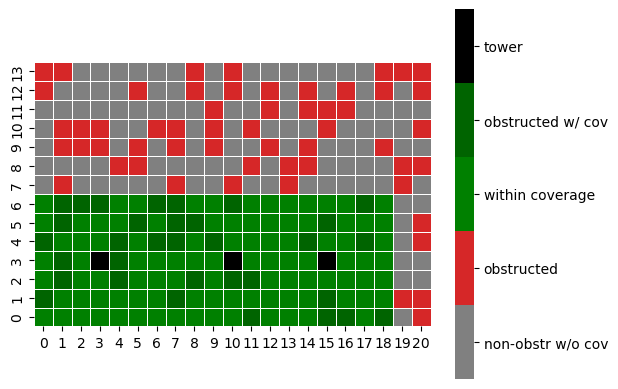

[[2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 3 3 2 3 0 1]
 [3 2 2 2 2 2 2 3 2 2 2 2 2 2 2 3 2 2 2 1 1]
 [2 3 2 2 3 2 2 2 3 2 3 3 2 2 2 2 2 2 2 0 0]
 [2 3 2 4 3 2 2 2 2 2 4 2 2 2 2 4 2 2 2 0 0]
 [3 2 2 2 3 2 3 3 2 3 2 2 2 2 3 2 2 3 2 0 1]
 [2 3 2 2 2 3 2 3 3 2 2 2 2 2 2 3 2 2 2 0 1]
 [2 3 3 3 2 2 3 3 2 2 3 2 2 2 2 2 2 3 2 0 0]
 [0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1]
 [0 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0]
 [0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1]]


In [1]:
import math

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


class CityGrid:
    def __init__(self, n, m, obstruction_cov=0.3, seed=None):
        self.n = n
        self.m = m
        self.grid = np.zeros(
            (m, n), dtype=int
        )  # 0 represents unobstructed, 1 represents obstructed blocks
        self.rng = np.random.default_rng(seed)
        self.place_obstructions(obstruction_cov)
        self.orig_grid = self.grid.copy()
        self.tower_graph = {}
        self.optimal_paths = {}

    def place_obstructions(self, coverage):
        # Calculate the number of needed obstructions to ensure strictly greater than the specified coverage
        n_obstructions = math.ceil(self.n * self.m * coverage)
        # Generate indices for obstructed blocks, ensuring no duplicate positions
        obstructed_idx = self.rng.choice(
            self.n * self.m, size=n_obstructions, replace=False
        )
        # Assign 1 (for obstructed blocks) to indices
        self.grid.reshape(-1)[obstructed_idx] = 1

    def place_tower(self, x, y, tower_range, display=False):
        # Check if the specified location is unobstructed
        if self.grid[y, x] == 0 or self.grid[y, x] == 2:
            # Place a tower with the given range
            # use max(0, idx) to prevent reversal
            temp = self.grid[
                max(0, y - tower_range) : y + tower_range + 1,
                max(0, x - tower_range) : x + tower_range + 1,
            ]  # 2 and 3 represent tower coverage for non-obstructed and obstructed blocks respectively
            self.grid[
                max(0, y - tower_range) : y + tower_range + 1,
                max(0, x - tower_range) : x + tower_range + 1,
            ] = np.where(temp < 2, temp + 2, temp)
            # self.grid[
            #     max(0, y - tower_range) : y + tower_range + 1,
            #     max(0, x - tower_range) : x + tower_range + 1,
            # ] += 2  # 2 and 3 represent tower coverage for non-obstructed and obstructed blocks respectively
            # Place the tower with value 4
            self.grid[y, x] = 4
            if display:
                temp_grid = self.orig_grid.copy()
                temp_grid[
                    max(0, y - tower_range) : y + tower_range + 1,
                    max(0, x - tower_range) : x + tower_range + 1,
                ] += 2
                self.visualize_grid(temp_grid)
        else:
            print("Tower placement is obstructed.")

    def visualize_grid(self, grid=None):
        if grid is None:
            grid = self.grid
        nu = np.unique(grid)
        # Define custom colormap
        all_col = ["grey", "tab:red", "green", "darkgreen", "black"]
        colors = all_col[nu[0] : nu[-1] + 1]
        cmap = ListedColormap(colors)
        # Plot heatmap
        ax = sns.heatmap(grid, cmap=cmap, cbar=True, linewidths=0.5, square=True)
        ax.invert_yaxis()
        # Specify colorbar labelling after it's been generated
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks(np.linspace(nu[0], nu[-1], len(nu) * 2 + 1)[1::2])
        colorbar.set_ticklabels(
            [
                "non-obstr w/o cov",
                "obstructed",
                "within coverage",
                "obstructed w/ cov",
                "tower",
            ][nu[0] : nu[-1] + 1]
        )

        plt.show()

    def visualize_obstructions(self):
        # Filter to only show obstructions
        obstructions = np.where((self.grid == 1) | (self.grid == 3), 1, 0)
        nu = np.unique(obstructions)
        # Define custom colormap
        cmap = ListedColormap(["grey", "black"])
        # Plot heatmap
        ax = sns.heatmap(
            obstructions, cmap=cmap, cbar=True, linewidths=0.5, square=True
        )
        ax.invert_yaxis()
        # Specify colorbar labelling after it's been generated
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks(np.linspace(nu[0], nu[-1], len(nu) * 2 + 1)[1::2])
        colorbar.set_ticklabels(["non-obstr", "obstructed"][nu[0] : nu[-1] + 1])

        plt.show()

    def visualize_towers(self):
        # Filter to only show towers
        towers = np.where(self.grid == 4, 1, 0)
        nu = np.unique(towers)
        # Define custom colormap
        cmap = ListedColormap(["grey", "black"])
        # Plot heatmap
        ax = sns.heatmap(towers, cmap=cmap, cbar=True, linewidths=0.5, square=True)
        ax.invert_yaxis()
        # Specify colorbar labelling after it's been generated
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks(np.linspace(nu[0], nu[-1], len(nu) * 2 + 1)[1::2])
        colorbar.set_ticklabels(["blocks", "towers"][nu[0] : nu[-1] + 1])

        plt.show()


my_city = CityGrid(21, 7 * 2, seed=42)
my_city.place_tower(3, 3, 3)
my_city.place_tower(10, 3, 3)
my_city.place_tower(15, 3, 3)
my_city.visualize_towers()
my_city.visualize_obstructions()
my_city.visualize_grid()
print(my_city.grid)